In [1]:
import Pkg; 

if split(pwd(),"/")[end] == "_paper_2"
    cd(joinpath(@__DIR__, "../../"))
    Pkg.activate("Project.toml")
end

using MorphoMolNotebooks
using MorphoMol

using StaticArrays
using Rotations
using Distances
using LinearAlgebra
using CairoMakie
using JLD2

  Activating project at `~/Doktor/Code/MorphoMol/MorphoMolNotebooks`


In [2]:
function are_intersecting(lock, key, lock_radii, key_radii)
    for i in 1:length(lock)
        for j in 1:length(key)
            if euclidean(lock[i], key[j]) < lock_radii[i] + key_radii[j]
                return true
            end
        end
    end
    return false
end

are_intersecting (generic function with 1 method)

In [3]:
function overlap(l, k, r_l, r_k, overlap_slope)
    ol = 0.0
    for (i, l_a) in enumerate(l)
        for (j, k_a) in enumerate(k)
            ol += max(0.0, r_k[j] + r_l[i] - euclidean(l_a, k_a))
        end
    end
    ol * overlap_slope
end

function lock_and_key_fit_with_overlap(lock, key, lock_radii, key_radii, min_dist, max_dist, rs, eta; t_dir = [0.0, 0.0, 1.0])
    xs = Vector{Float64}([])
    Vs = Vector{Float64}([])
    As = Vector{Float64}([])
    Ms = Vector{Float64}([])
    Gs = Vector{Float64}([])
    Fsols = Vector{Float64}([])

    prefactors = MorphoMol.Energies.get_prefactors(rs, eta)
    radii = vcat(lock_radii, key_radii)

    t_key = deepcopy(key)

    for d in min_dist:0.01:max_dist
        t = d .* t_dir
        t_key = [elem + t for elem in key]

        centers = vcat(lock, t_key)

        push!(xs, d)

        V, A, M, G = MorphoMol.Energies.get_geometric_measures(vcat(centers...), radii, rs, 100.0)
        push!(Vs, V)
        push!(As, A)
        push!(Ms, M)
        push!(Gs, G)

        ol = overlap(lock, t_key, lock_radii, key_radii, 1.0)
        fsol = prefactors[1] * V + prefactors[2] * A + prefactors[3] * M + prefactors[4] * G + ol
        push!(Fsols, fsol)
        
    end

    return xs, Fsols, Vs, As, Ms, Gs
end

lock_and_key_fit_with_overlap (generic function with 1 method)

In [5]:
# ILE!
template_centers = MorphoMol.Utilities.TWOTMVSU_EXPERIMENTAL_ASSEMBLY["6r7m"]["template_centers"]
r = MorphoMol.Utilities.TWOTMVSU_EXPERIMENTAL_ASSEMBLY["6r7m"]["template_radii"]
assembly_state = MorphoMol.Utilities.TWOTMVSU_EXPERIMENTAL_ASSEMBLY["6r7m"]["state"]

rlz = MorphoMol.Utilities.get_matrix_realization_per_mol(assembly_state, template_centers)
c1 = [Vector{Float64}(e) for e in eachcol(rlz[1])]
r1 = r
c2 = [Vector{Float64}(e) for e in eachcol(rlz[2])]
r2 = r

c1 = c1[1046:1053]
r1 = r1[1046:1053]

lck = deepcopy(c2)
ky = deepcopy(c1)
r_lck = deepcopy(r2)
r_ky = deepcopy(r1)

v_detach = [0.0, 0.0, 0.0]

for (h,l) in enumerate(lck)
    for (i,k) in enumerate(ky)
        ol = r_ky[i] + r_lck[h] + 2.8 - euclidean(l, k)
        if ol > 0.0
            v_detach += ol .* (k-l)
        end
    end
end
v_detach = normalize(v_detach)

# for (i,f) in enumerate(0.0:0.01:10.0)
#     c = [[e + (f .* v_detach) for e in ky]; lck]
#     r = [r_ky; r_lck]

#     MorphoMolNotebooks.configuration_to_poly(false)
# end

3-element Vector{Float64}:
 -0.5944731976327163
 -0.5387764891199394
  0.5969267225279207

In [6]:
overlap(lck, ky, r_lck, r_ky, 1.0)

0.5467793107255323

In [8]:
rs = 1.4
eta = 0.3665

xs, Fsols, Vs, As, Ms, Gs = lock_and_key_fit_with_overlap(lck, ky, r_lck, r_ky, 0.0, 6.0, rs, eta; t_dir=v_detach);

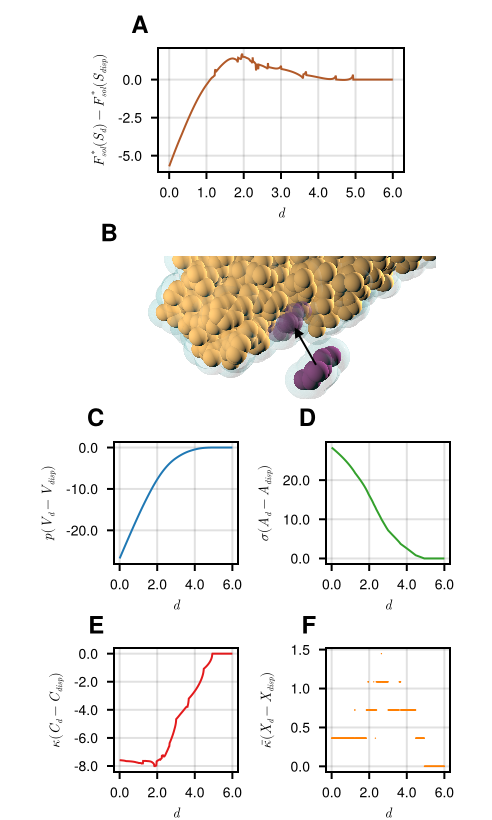

In [9]:
paired_colors = cgrad(:Paired_12, 12, categorical = true)
#xs = 0:length(Vs)-1
pf = MorphoMol.Energies.get_prefactors(1.4, 0.3665)

pt_per_in = 72
width = 3.42
height = 5.7
f_size = (pt_per_in * width, pt_per_in * height)
fs = 7
border_width = 0.5
fig = Figure(size = f_size, fontsize = fs)

colsize = f_size[1] * 0.5
png_dimension = colsize / 1.6
plot_width = colsize / 2.0
plot_height = colsize / 2.0
pad = 1
ms = 1

xticks = [0.0, 2.0, 4.0, 6.0]

ga = fig[1, 1:2] = GridLayout()
lines(ga[1,1], xs, pf[1] * (Vs .- Vs[end]) + pf[2] * (As .- As[end]) + pf[3] * (Ms .- Ms[end]) + pf[4] * (Gs .- Gs[end]), color = paired_colors[12], linewidth = 1,
    axis = (xlabel = L"d", ylabel = L"F^*_{sol}(S_d) - F^*_{sol}(S_{disp})", ylabelrotation = pi/2, width = 2.0 * plot_width, height = plot_height, xticksize = 3.0, yticksize = 3.0, xtickformat = "{:.1f}", ytickformat = "{:.1f}"))

gb = fig[2, 1:2] = GridLayout()
img = load("notebooks/_paper_2//pngs/4/x.png")
ax, _ = image(gb[1, 1], rotr90(img),
    axis = (
        width = 2*png_dimension, 
        height = png_dimension, 
        title = "",
        spinewidth=border_width
        )
    )

hidespines!(ax)
hidedecorations!(ax)

#garrow = fig[2, 1:2] = GridLayout()
arrows!(ax, [1250], [300], [-400], [700], arrowsize = 7, lengthscale = 0.3)
#scatter!(ax, [1150], [400], markersize = 6, marker = 'd', color = :black, strokewidth = 0.7)

gc = fig[3, 1] = GridLayout()
lines(gc[1,1], xs, pf[1] .* (Vs .- Vs[end]), color = paired_colors[2], linewidth = 1, axis = (xticks = [0.0, 2.0, 4.0, 6.0], xlabel = L"d", ylabel = L"p(V_d - V_{disp})", ylabelrotation = pi/2, width = plot_width, height = plot_height, xticksize = 3.0, yticksize = 3.0, xtickformat = "{:.1f}", ytickformat = "{:.1f}"))

gd = fig[3, 2] = GridLayout()
lines(gd[1,1], xs, pf[2] .* (As .- As[end]), color = paired_colors[4], linewidth = 1, axis = (xticks = [0.0, 2.0, 4.0, 6.0], xlabel = L"d", ylabel = L"\sigma(A_d - A_{disp})", ylabelrotation = pi/2, width = plot_width, height = plot_height, xticksize = 3.0, yticksize = 3.0, xtickformat = "{:.1f}", ytickformat = "{:.1f}"))

ge = fig[4, 1] = GridLayout()
lines(ge[1,1], xs, pf[3] .* (Ms .- Ms[end]), color = paired_colors[6], linewidth = 1, axis = (xticks = [0.0, 2.0, 4.0, 6.0], xlabel = L"d", ylabel = L"\kappa (C_d - C_{disp})", ylabelrotation = pi/2, width = plot_width, height = plot_height, xticksize = 3.0, yticksize = 3.0, xtickformat = "{:.1f}", ytickformat = "{:.1f}"))

gf = fig[4, 2] = GridLayout()
scatter(gf[1,1], xs, pf[4] .* (Gs .- Gs[end]), color = paired_colors[8], markersize = 1, axis = (xticks = [0.0, 2.0, 4.0, 6.0], xlabel = L"d", ylabel = L"\overline{\kappa} (X_d - X_{disp})", ylabelrotation = pi/2, width = plot_width, height = plot_height, xticksize = 3.0, yticksize = 3.0, xtickformat = "{:.1f}", ytickformat = "{:.1f}"))

for (label, layout) in zip(["A", "B", "C", "D", "E", "F", "G", "H", "I"], [ga, gb, gc, gd, ge, gf])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 12,
        font = :bold,
        padding = (0, 5, 5, 0),
        halign = :right)
end

rowgap!(fig.layout, 0)
colgap!(fig.layout, 40)
cs = 0.3
rs = 0.3
colsize!(fig.layout, 1, Relative(cs))
colsize!(fig.layout, 2, Relative(cs))
rowsize!(fig.layout, 1, Relative(rs))
rowsize!(fig.layout, 2, Relative(rs))

save(string("notebooks/_paper_2/output/measure_deep_dive_ILE.pdf"), fig, pt_per_unit = 1)
fig